# Preference Learning Report Visualizations

Explore the saved `metrics.json` artifacts for each persona/dataset/model run, aggregate them into convenient tables, and generate visual summaries (precision/recall/Jaccard, rank correlations, etc.).

In [1]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

RESULTS_ROOT = Path('../../results') / 'full_run_dec8' / 'preference_learning'
PLOT_STYLE = dict(s=80, alpha=0.7, edgecolor='black')

sns.set_theme(style='whitegrid')


In [2]:
def load_metrics(root: Path = RESULTS_ROOT) -> pd.DataFrame:
    records: List[Dict[str, object]] = []
    for persona_dir in sorted(root.iterdir()):
        if not persona_dir.is_dir():
            continue
        persona = persona_dir.name
        for experiment_dir in sorted(persona_dir.iterdir()):
            metrics_path = experiment_dir / 'metrics.json'
            summary_path = experiment_dir / 'summary.json'
            if not metrics_path.exists() or not summary_path.exists():
                continue
            summary = json.loads(summary_path.read_text())
            with metrics_path.open('r') as handle:
                metrics = json.load(handle)
            dataset_name = summary.get('dataset')
            model_name = summary.get('model')
            for instance_id, payload in metrics.items():
                gt = payload.get('ground_truth', [])
                for k, stats in (payload.get('top_k') or {}).items():
                    rank_corr = stats.get('rank_correlation') or {}
                    records.append(
                        {
                            'persona': persona,
                            'dataset': dataset_name,
                            'model': model_name,
                            'experiment': experiment_dir.name,
                            'instance_id': int(instance_id),
                            'k': int(k),
                            'hits': stats.get('hits', 0.0),
                            'precision': stats.get('precision', 0.0),
                            'recall': stats.get('recall', 0.0),
                            'jaccard': stats.get('jaccard', 0.0),
                            'spearman': rank_corr.get('spearman', 0.0),
                            'kendall': rank_corr.get('kendall', 0.0),
                            'ground_truth_size': len(gt),
                        }
                    )
    return pd.DataFrame(records)

metrics_df = load_metrics()
print(f'Loaded {len(metrics_df)} metric rows from {metrics_df.experiment.nunique()} experiments.')
metrics_df.head()


Loaded 576 metric rows from 12 experiments.


,persona,dataset,model,experiment,instance_id,k,hits,precision,recall,jaccard,spearman,kendall,ground_truth_size
0,layperson,open_compas,decision_tree,open_compas__decision_tree_pareto,133,1,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,14
1,layperson,open_compas,decision_tree,open_compas__decision_tree_pareto,133,3,2.0,0.666667,0.666667,0.500000,0.200000,0.000000,14
2,layperson,open_compas,decision_tree,open_compas__decision_tree_pareto,133,5,4.0,0.800000,0.800000,0.666667,0.485714,0.333333,14
3,layperson,open_compas,decision_tree,open_compas__decision_tree_pareto,609,1,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,11
4,layperson,open_compas,decision_tree,open_compas__decision_tree_pareto,609,3,3.0,1.000000,1.000000,1.000000,1.000000,1.000000,11


In [3]:
def compact_name(name: str) -> str:
    parts = [part for part in name.split('_') if part]
    if len(parts) <= 2:
        trimmed = parts
    else:
        trimmed = parts[1:-1]
    return '_'.join(part[0] for part in trimmed if part)

with pd.option_context('mode.chained_assignment', None):
    metrics_df['experiment_short'] = metrics_df['experiment'].apply(compact_name)


In [4]:
agg_metrics = (
    metrics_df
    .groupby(['persona', 'dataset', 'model', 'experiment_short', 'k'])
    [['precision', 'recall', 'jaccard', 'spearman', 'kendall']]
    .mean()
    .reset_index()
)
agg_metrics.head()


,persona,dataset,model,experiment_short,k,precision,recall,jaccard,spearman,kendall
0,layperson,open_compas,decision_tree,c_d_t,1,0.625000,0.625000,0.625000,-0.375000,-0.375000
1,layperson,open_compas,decision_tree,c_d_t,3,0.833333,0.833333,0.775000,0.550000,0.475000
2,layperson,open_compas,decision_tree,c_d_t,5,0.900000,0.900000,0.833333,0.685714,0.616667
3,layperson,open_compas,gradient_boosting,c_g_b,1,0.750000,0.750000,0.750000,-0.250000,-0.250000
4,layperson,open_compas,gradient_boosting,c_g_b,3,0.916667,0.916667,0.875000,0.350000,0.291667


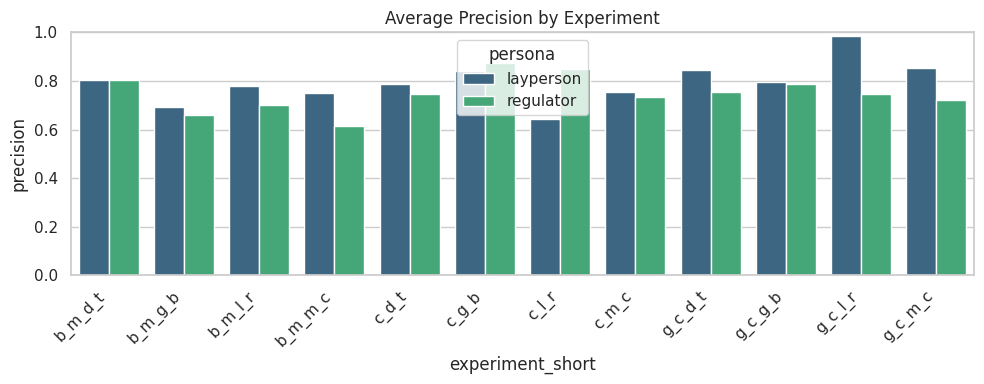

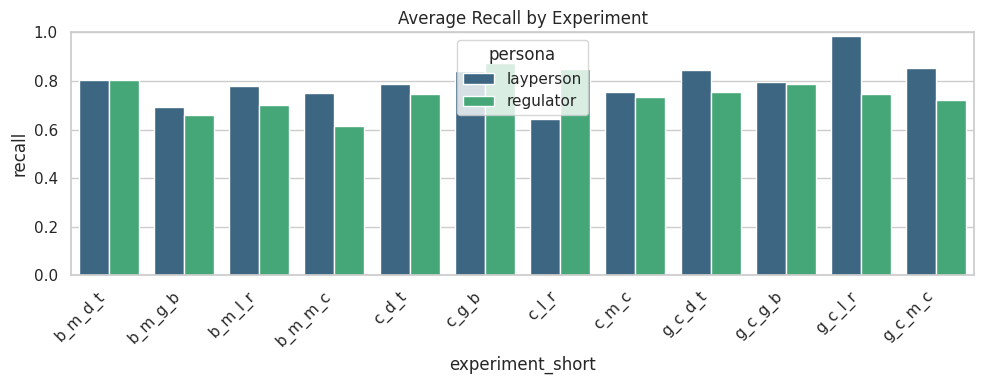

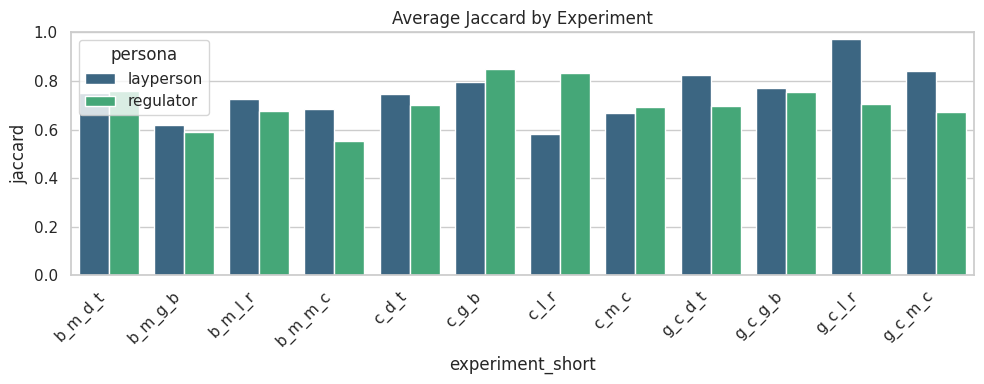

In [5]:
def plot_bar(metric: str, data: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 4))
    sns.barplot(
        data=data,
        x='experiment_short',
        y=metric,
        hue='persona',
        palette='viridis',
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(f'Average {metric.title()} by Experiment')
    plt.tight_layout()

plot_bar_data = (
    metrics_df.groupby(['persona', 'experiment_short'])[['precision', 'recall', 'jaccard']]
    .mean()
    .reset_index()
)
for metric in ['precision', 'recall', 'jaccard']:
    plot_bar(metric, plot_bar_data)
    plt.show()


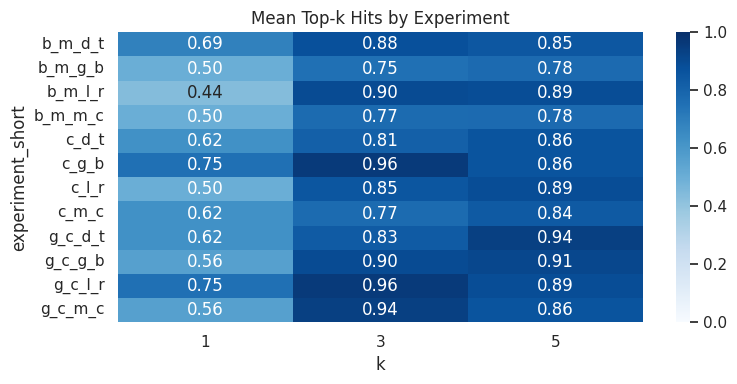

In [6]:
# heatmap_df = (
#     metrics_df.pivot_table(
#         index='experiment_short',
#         columns='k',
#         values='hits',
#         aggfunc='mean'
#     )
# )

heatmap_df = (
    metrics_df.pivot_table(
        index='experiment_short',
        columns='k',
        values='precision',  # or 'recall' / 'jaccard'
        aggfunc='mean',
    )
)
plt.figure(figsize=(8, max(4, len(heatmap_df) * 0.3)))
sns.heatmap(heatmap_df, annot=True, fmt='.2f', vmin=0, vmax=1, cmap='Blues')
plt.title('Mean Top-k Hits by Experiment')
plt.tight_layout()
plt.show()


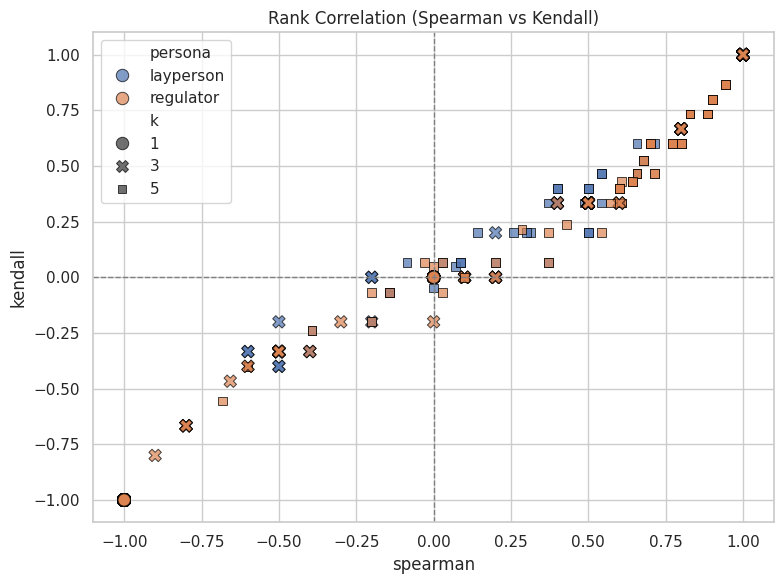

In [6]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=metrics_df,
    x='spearman',
    y='kendall',
    hue='persona',
    style='k',
    palette='deep',
    **PLOT_STYLE,
)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Rank Correlation (Spearman vs Kendall)')
plt.tight_layout()
plt.show()


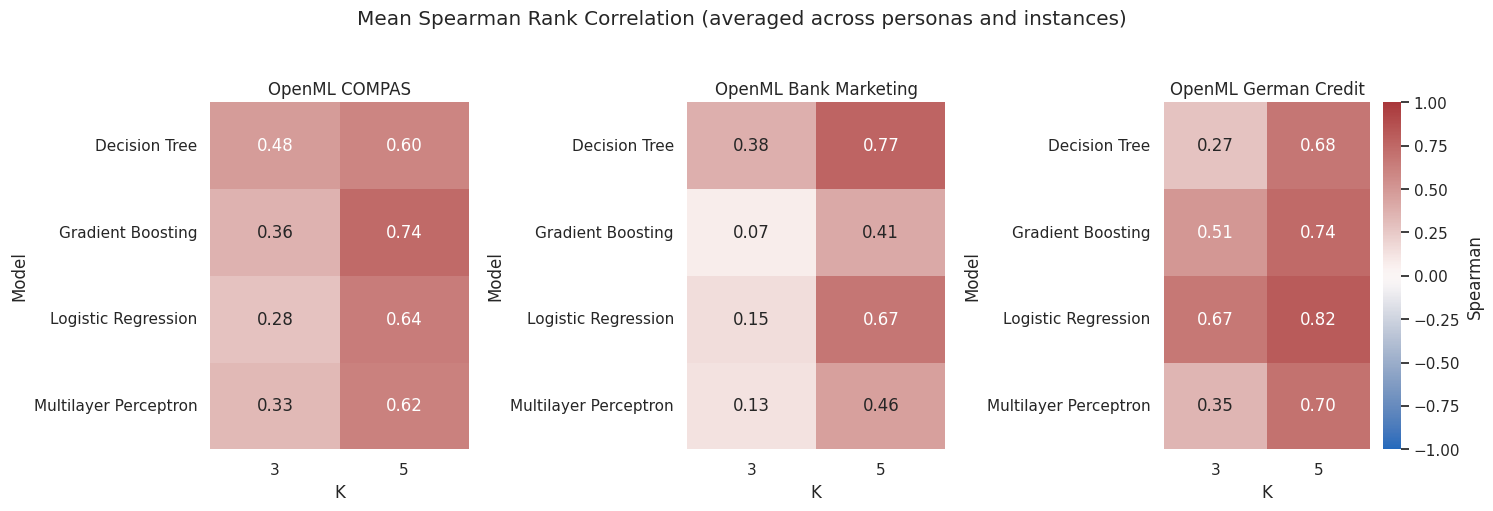

In [7]:
DATASET_LABELS = {
    'open_compas': 'OpenML COMPAS',
    'openml_bank_marketing': 'OpenML Bank Marketing',
    'openml_german_credit': 'OpenML German Credit',
}
MODEL_LABELS = {
    'decision_tree': 'Decision Tree',
    'gradient_boosting': 'Gradient Boosting',
    'logistic_regression': 'Logistic Regression',
    'mlp_classifier': 'Multilayer Perceptron',
}
K_VALUES = [3, 5]

def _format_label(name: str) -> str:
    return name.replace('_', ' ').title() if isinstance(name, str) else 'Unknown'

PERSONAS_TO_AVERAGE = ['layperson', 'regulator']

spearman_heatmap_df = (
    metrics_df[metrics_df['persona'].isin(PERSONAS_TO_AVERAGE) & metrics_df['k'].isin(K_VALUES)]
    .groupby(['persona', 'dataset', 'model', 'k'])['spearman']
    .mean()  # mean over instances within each persona
    .reset_index()
    .groupby(['dataset', 'model', 'k'])['spearman']
    .mean()  # mean over personas (equal weight)
    .reset_index()
)

spearman_heatmap_df['dataset_label'] = (
    spearman_heatmap_df['dataset']
    .map(DATASET_LABELS)
    .fillna(spearman_heatmap_df['dataset'].apply(_format_label))
)

spearman_heatmap_df['model_label'] = (
    spearman_heatmap_df['model']
    .map(MODEL_LABELS)
    .fillna(spearman_heatmap_df['model'].apply(_format_label))
)

datasets_to_plot = ['open_compas', 'openml_bank_marketing', 'openml_german_credit']

plot_payloads = []
max_rows = 0
for dataset_key in datasets_to_plot:
    dataset_subset = spearman_heatmap_df[spearman_heatmap_df['dataset'] == dataset_key].copy()
    if dataset_subset.empty:
        continue

    dataset_label = dataset_subset['dataset_label'].iloc[0]
    present_models = set(dataset_subset['model'])
    model_order = [
        MODEL_LABELS.get(model_key, _format_label(model_key))
        for model_key in MODEL_LABELS
        if model_key in present_models
    ]
    if not model_order:
        model_order = dataset_subset['model_label'].drop_duplicates().tolist()

    pivot_table = (
        dataset_subset
        .pivot(index='model_label', columns='k', values='spearman')
        .reindex(model_order)
        .reindex(columns=K_VALUES)
    )
    if pivot_table.empty:
        continue

    plot_payloads.append((dataset_label, pivot_table))
    max_rows = max(max_rows, len(pivot_table))

if plot_payloads:
    fig_width = max(5 * len(plot_payloads), 6)
    fig_height = max(0.8 * max_rows + 2, 4)
    fig, axes = plt.subplots(1, len(plot_payloads), figsize=(fig_width, fig_height), squeeze=False)
    axes_iter = axes.flatten()
    for idx, (dataset_label, pivot_table) in enumerate(plot_payloads):
        sns.heatmap(
            pivot_table,
            annot=True,
            fmt='.2f',
            cmap='vlag',
            vmin=-1,
            vmax=1,
            ax=axes_iter[idx],
            cbar=idx == len(plot_payloads) - 1,
            cbar_kws={'label': 'Spearman'} if idx == len(plot_payloads) - 1 else None,
        )
        axes_iter[idx].set_title(dataset_label)
        axes_iter[idx].set_xlabel('K')
        axes_iter[idx].set_ylabel('Model')

    fig.suptitle('Mean Spearman Rank Correlation (averaged across personas and instances)')
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print('No Spearman data available for the selected datasets.')


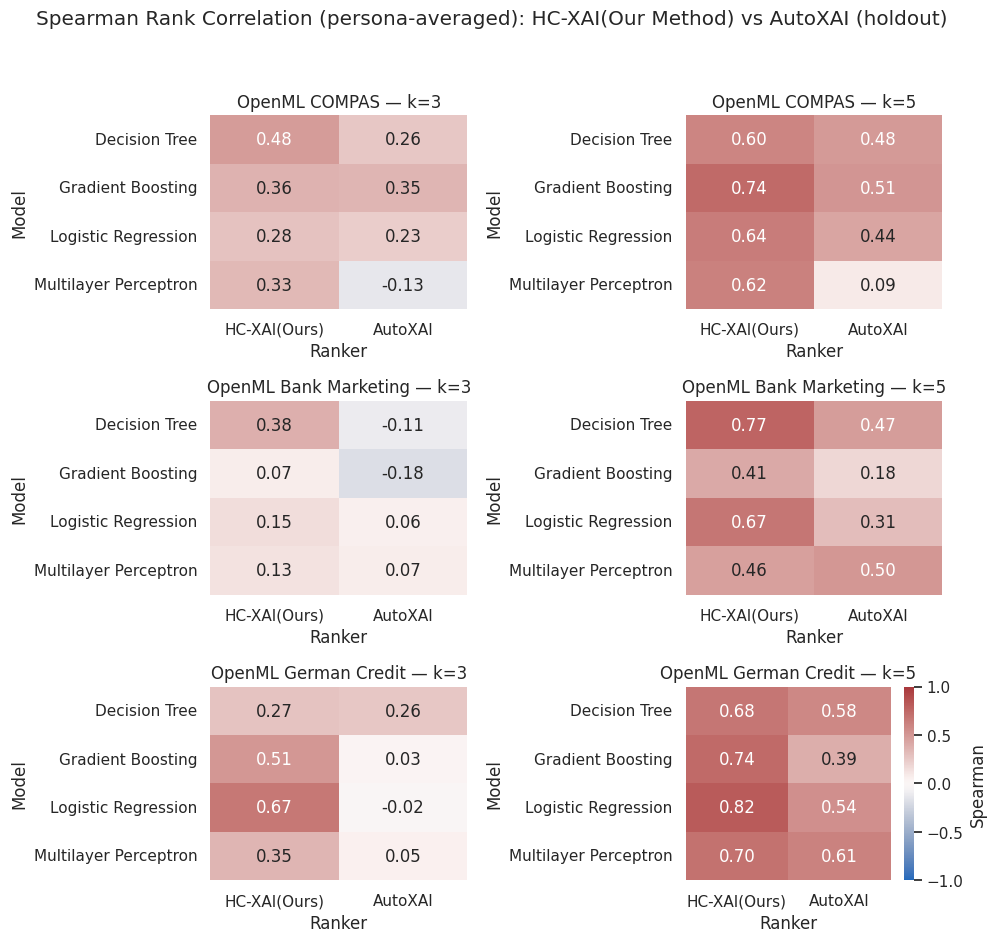

In [10]:
AUTOXAI_ROOT = Path('../../results') / 'full_run_dec8' / 'baslines' / 'holdout_eval'
AUTOXAI_SPLIT_SET = 'test'

def load_autoxai_holdout(root: Path = AUTOXAI_ROOT, *, split_set: str = AUTOXAI_SPLIT_SET) -> pd.DataFrame:
    records: List[Dict[str, object]] = []
    if not root.exists():
        return pd.DataFrame(records)

    for path in sorted(root.glob('autoxai_holdout_eval__*.json')):
        parts = path.stem.split('__')
        if len(parts) < 5 or parts[0] != 'autoxai_holdout_eval':
            continue
        dataset_key, model_key, persona, run_split_set = parts[1], parts[2], parts[3], parts[4]
        if split_set and run_split_set != split_set:
            continue

        payload = json.loads(path.read_text())
        topk = payload.get('top_k_evaluation') or {}
        mean_topk = topk.get('mean_top_k') or {}
        for k in K_VALUES:
            corr = (mean_topk.get(str(k)) or {}).get('rank_correlation') or {}
            records.append(
                {
                    'dataset': dataset_key,
                    'model': model_key,
                    'persona': persona,
                    'k': int(k),
                    'spearman': corr.get('spearman', 0.0),
                }
            )

    return pd.DataFrame(records)


hc_spearman_df = (
    metrics_df[metrics_df['persona'].isin(PERSONAS_TO_AVERAGE) & metrics_df['k'].isin(K_VALUES)]
    .groupby(['persona', 'dataset', 'model', 'k'])['spearman']
    .mean()  # mean over instances within each persona
    .reset_index()
    .groupby(['dataset', 'model', 'k'])['spearman']
    .mean()  # mean over personas (equal weight)
    .reset_index()
    .rename(columns={'spearman': 'hc_xai_spearman'})
)

autoxai_metrics_df = load_autoxai_holdout()
autoxai_spearman_df = (
    autoxai_metrics_df[autoxai_metrics_df['persona'].isin(PERSONAS_TO_AVERAGE) & autoxai_metrics_df['k'].isin(K_VALUES)]
    .groupby(['persona', 'dataset', 'model', 'k'])['spearman']
    .mean()  # mean over instances within each persona (already mean_top_k, but keep symmetry)
    .reset_index()
    .groupby(['dataset', 'model', 'k'])['spearman']
    .mean()  # mean over personas (equal weight)
    .reset_index()
    .rename(columns={'spearman': 'autoxai_spearman'})
)

combined_df = hc_spearman_df.merge(
    autoxai_spearman_df,
    on=['dataset', 'model', 'k'],
    how='outer',
)

combined_df['dataset_label'] = (
    combined_df['dataset']
    .map(DATASET_LABELS)
    .fillna(combined_df['dataset'].apply(_format_label))
)
combined_df['model_label'] = (
    combined_df['model']
    .map(MODEL_LABELS)
    .fillna(combined_df['model'].apply(_format_label))
)

n_rows = len(datasets_to_plot)
n_cols = len(K_VALUES)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3.2 * n_rows), squeeze=False)

for row_idx, dataset_key in enumerate(datasets_to_plot):
    dataset_label = DATASET_LABELS.get(dataset_key, _format_label(dataset_key))
    for col_idx, k in enumerate(K_VALUES):
        ax = axes[row_idx][col_idx]
        subset = combined_df[(combined_df['dataset'] == dataset_key) & (combined_df['k'] == int(k))].copy()
        if subset.empty:
            ax.axis('off')
            continue

        present_models = set(subset['model'])
        model_order = [
            MODEL_LABELS.get(model_key, _format_label(model_key))
            for model_key in MODEL_LABELS
            if model_key in present_models
        ]
        if not model_order:
            model_order = subset['model_label'].drop_duplicates().tolist()

        pivot_table = (
            subset
            .set_index('model_label')[['hc_xai_spearman', 'autoxai_spearman']]
            .rename(columns={'hc_xai_spearman': 'HC-XAI(Ours)', 'autoxai_spearman': 'AutoXAI'})
            .reindex(model_order)
        )

        mask = pivot_table.isna()
        sns.heatmap(
            pivot_table,
            annot=True,
            fmt='.2f',
            cmap='vlag',
            vmin=-1,
            vmax=1,
            mask=mask,
            ax=ax,
            cbar=(row_idx == n_rows - 1 and col_idx == n_cols - 1),
            cbar_kws={'label': 'Spearman'} if (row_idx == n_rows - 1 and col_idx == n_cols - 1) else None,
        )
        ax.set_title(f"{dataset_label} — k={k}")
        ax.set_xlabel('Ranker')
        ax.set_ylabel('Model')

fig.suptitle('Spearman Rank Correlation (persona-averaged): HC-XAI(Our Method) vs AutoXAI (holdout)')
fig.tight_layout(rect=[0, 0, 1, 0.95])
# fig.savefig("spearman_heatmaps.svg", bbox_inches="tight")  # or .pdf
fig.savefig("spearman_heatmaps.png", dpi=300, bbox_inches="tight")
plt.show()
